In [1]:
"""
A simple test to check if the RFAE model loads and runs properly
on toy datasets, producing train/test embeddings.
"""

from rfae import RFAE
from rfphate import RFPHATE
from sklearn.datasets import fetch_openml, load_digits, fetch_kddcup99
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np

# Loading functions

In [2]:
from sklearn.datasets import fetch_openml, load_digits, fetch_covtype
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

def load_dataset(data_name="optdigits", subsample_size=None, random_state=42):

    # Load full dataset
    if data_name == "mnist":
        mnist = fetch_openml(data_id=554, as_frame=False)
        x = mnist.data.astype(float)
        y = mnist.target.astype(int)

    elif data_name == "fmnist":
        FMNIST_LABELS = {
            "0": "T-shirt/top",
            "1": "Trouser",
            "2": "Pullover",
            "3": "Dress",
            "4": "Coat",
            "5": "Sandal",
            "6": "Shirt",
            "7": "Sneaker",
            "8": "Bag",
            "9": "Ankle boot",
        }
        fmnist = fetch_openml(data_id=40996, as_frame=False)
        x = fmnist.data.astype(float)
        y_raw = np.array(fmnist.target)      # ["0","1",...]
        y = np.array([FMNIST_LABELS[t] for t in y_raw])

    elif data_name == "usps":
        usps = fetch_openml(data_id=41082, as_frame=False)
        x = usps.data.astype(float)
        y = usps.target.astype(int)

    elif data_name == "optdigits":
        digits = load_digits()
        x = digits.data.astype(float)
        y = digits.target.astype(int)

    elif data_name == "coil20":
        coil = fetch_openml(data_id=40979, as_frame=False)
        x = coil.data.astype(float)
        y = coil.target.astype(int)

    elif data_name == "covtype":
        COVTYPE_LABELS = {
            1: "Spruce/Fir",
            2: "Lodgepole Pine",
            3: "Ponderosa Pine",
            4: "Cottonwood/Willow",
            5: "Aspen",
            6: "Douglas-fir",
            7: "Krummholz",
        }
    
        cov = fetch_covtype(as_frame=False)
        x = cov.data.astype(float)
        y_int = cov.target.astype(int)
        y = np.array([COVTYPE_LABELS[i] for i in y_int])
    
        print("Loaded covtype:", x.shape, y.shape)

    elif data_name == "kdd99":
        print("Loading KDD Cup 1999 dataset (10% subset)...")
        kdd = fetch_kddcup99(as_frame=False, percent10=True)
    
        X_raw = kdd.data
        y_raw = kdd.target  # bytes
    
        # Convert byte strings → UTF-8 strings
        y = np.array([lbl.decode("utf-8") for lbl in y_raw])
    
        # Convert categorical byte features to numeric where possible
        # For RF-AE, convert non-numeric columns using one-hot
        X = []
        for col in X_raw.T:
            if col.dtype.kind in {'S', 'O'}:  # bytes/categorical
                # convert bytes to strings
                col = np.array([c.decode("utf-8") for c in col])
                # one-hot encode
                _, onehot = np.unique(col, return_inverse=True)
                X.append(onehot.reshape(-1, 1))
            else:
                X.append(col.reshape(-1, 1))
    
        X = np.hstack(X).astype(float)
    
        x = X
        print(f"KDD99 loaded: X={x.shape}, y={y.shape}")

    else:
        raise ValueError(f"Unknown dataset: {data_name}")

    print(f"Loaded {data_name}: X={x.shape}, y={y.shape}")

    # Optional stratified subsample BEFORE train/test split
    if subsample_size is not None and subsample_size < len(y):
        sss = StratifiedShuffleSplit(
            n_splits=1,
            train_size=subsample_size,
            random_state=random_state
        )
        idx_sub, _ = next(sss.split(x, y))
        x = x[idx_sub]
        y = y[idx_sub]
        print(f"Stratified subsample: {x.shape[0]} samples retained.")

    return x, y

# Load data

In [3]:
data_name = "fmnist"
seed = 999
x, y = load_dataset(data_name, subsample_size=None, random_state=seed)

print(f"Final dataset: Samples={len(x)}, Features={x.shape[1]}")

Loaded fmnist: X=(70000, 784), y=(70000,)
Final dataset: Samples=70000, Features=784



# Split into train/test sets


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)

# Initialize and fit RFAE


In [5]:
model = RFAE(
    n_components=2,
    epochs=200,
    lam=0.01,
    recon_loss_type='jsd',
    random_state=seed
    )


emb_train = model.fit_transform(x_train, y_train)

print("Embedding shapes:", emb_train.shape)

2025-11-23 18:31:05,826 - INFO - Using device: mps


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 63000 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 8.78 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 153.93 seconds.
    Calculating KMeans...
    Calculated KMeans in 11.15 seconds.
  Calculated landmark operator in 165.08 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 0.46 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.15 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -1.8% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 1.07 seconds.
Calculated PHATE in 181.66 seconds.
2025-11-23 18:34:18,062 - INFO - Initializing RF-AE module with output activation: softmax
2025-11-23 18:34:18,062 - INFO - Input shape: 2000
2025-11-23 18:34:18

In [6]:
emb_test = model.transform(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


# Visualization

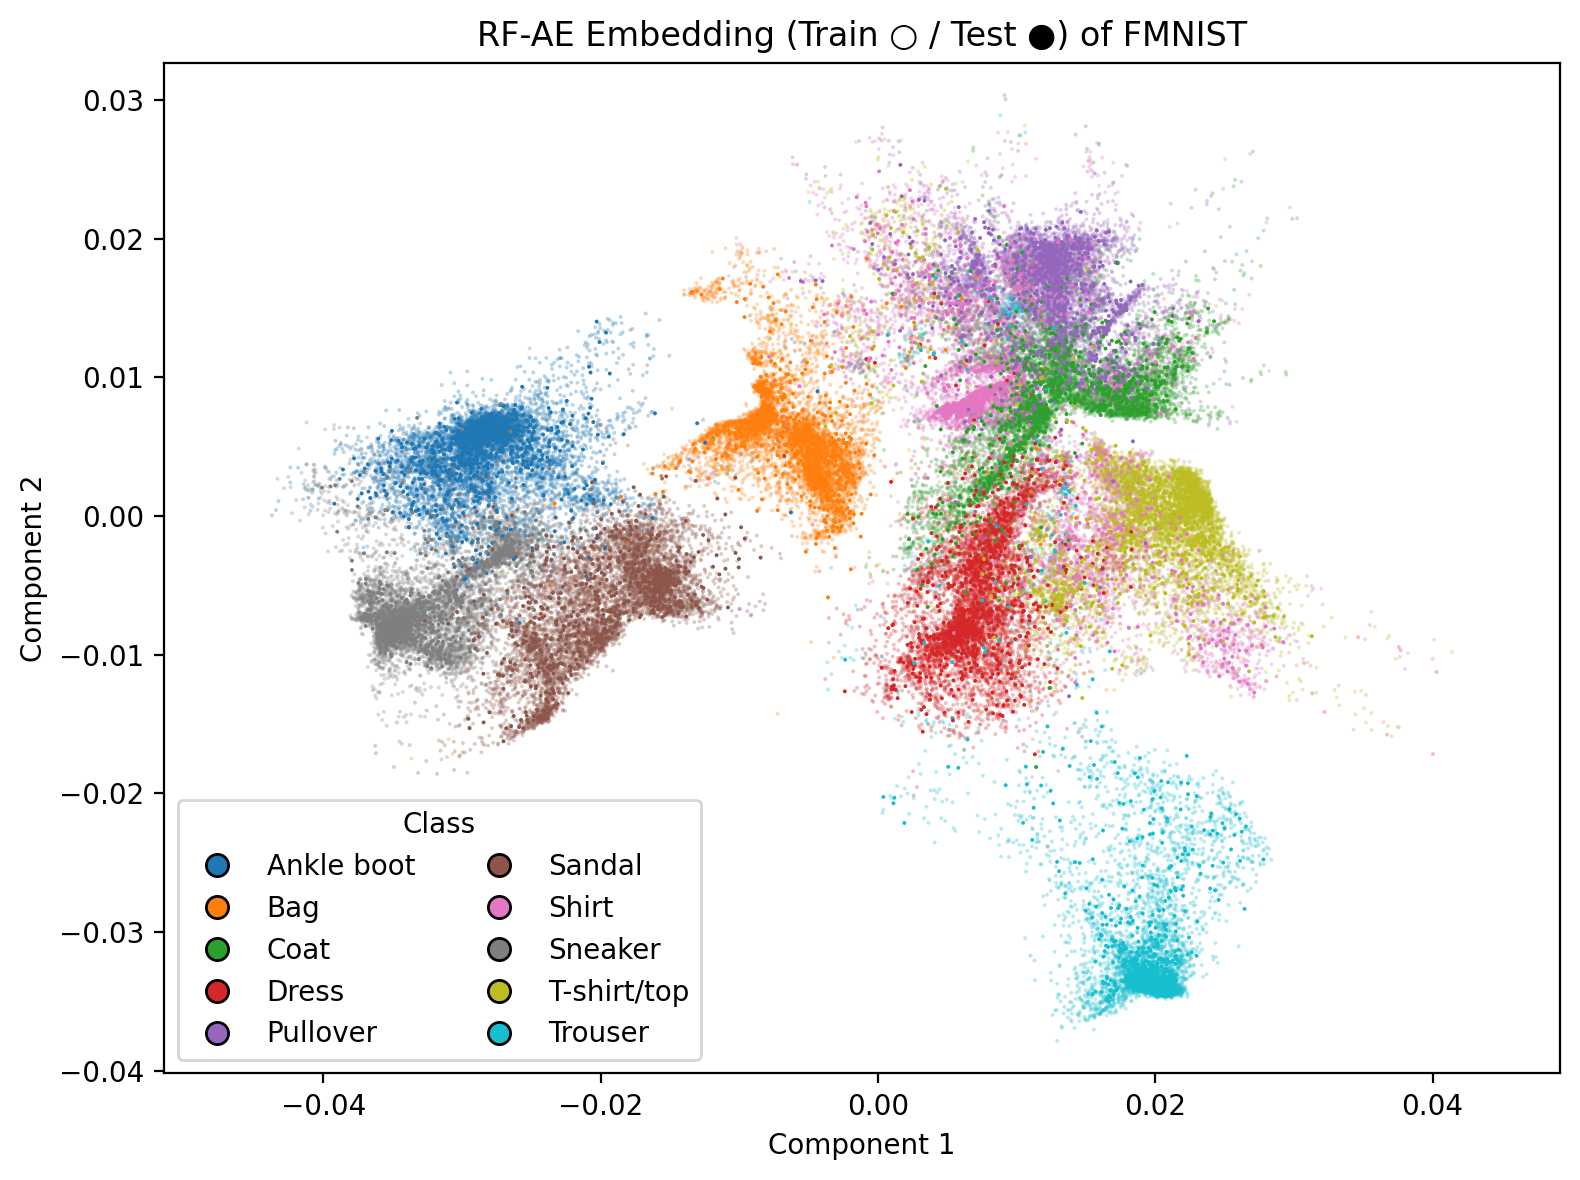

In [7]:
plt.figure(figsize=(8, 6), dpi=200)

# ----------------------------------------------------------
# Convert string labels → integer color codes for scatter
# ----------------------------------------------------------
classes = np.unique(np.concatenate([y_train, y_test]))
class_to_int = {cls: i for i, cls in enumerate(classes)}

y_train_colors = np.array([class_to_int[c] for c in y_train])
y_test_colors  = np.array([class_to_int[c] for c in y_test])

# ----------------------------------------------------------
# Plot training (circles) and test (triangles)
# ----------------------------------------------------------
train_scatter = plt.scatter(
    emb_train[:, 0], emb_train[:, 1],
    c=y_train_colors, cmap='tab10',
    s=2, alpha=0.3, marker='o', linewidths=0
)
test_scatter = plt.scatter(
    emb_test[:, 0], emb_test[:, 1],
    c=y_test_colors, cmap='tab10',
    s=2, alpha=1, marker='o', linewidths=0
)

plt.title(f"RF-AE Embedding (Train ○ / Test ●) of {data_name.upper()}")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.axis("equal")

# ----------------------------------------------------------
# Dot-based legend: labels remain strings
# ----------------------------------------------------------
cmap = plt.get_cmap('tab10')
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='none',
        markerfacecolor=cmap(class_to_int[cls] % 10),
        markersize=8,
        label=str(cls)
    )
    for cls in classes
]

plt.legend(
    handles=handles,
    title="Class",
    loc='best',
    frameon=True,
    ncol=2
)

plt.tight_layout()
plt.show()